In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, BatchNormalization, Dropout
from keras import optimizers

%matplotlib inline
%load_ext pycodestyle_magic

Using TensorFlow backend.


In [2]:
%cd ../weather_data/
v1 = pd.read_csv('v1_obfs.csv')
v2 = pd.read_csv('v2_obfs.csv')
v4 = pd.read_csv('v4_obfs.csv')
v8 = pd.read_csv('v8_obfs.csv')
v11 = pd.read_csv('v11_obfs.csv')
v14 = pd.read_csv('v14_obfs.csv')
v15 = pd.read_csv('v15_obfs.csv')
v19 = pd.read_csv('v19_obfs.csv')

/Users/MD/time_series_clustering/weather_data


In [3]:
v = [v1, v2, v4, v8, v11, v14, v15, v19]
v_dict = {'v1': v1, 'v2': v2, 'v4': v4, 'v8': v8,
          'v11':v11, 'v14': v14, 'v15': v15, 'v19': v19}


In [4]:
kmeans = pd.read_pickle('../k_means_strong_features_v.pkl')

In [10]:
def check_constant(vals):
    return len(set(vals)) <= 1


def cluster_splitting(clusters, v_dict):
    data = []
    for _, row in clusters.iterrows():
        ts = v_dict[row['File']][row['column']]
        if ts.isnull().any() or  check_constant(ts.values[3834:5113]):
            continue
        else:
#             print (row['File'], row['column'])
            data.append(ts.values[:5113])
    print (len(data))
    return data


cluster_0 = kmeans[kmeans['cluster']==0][['File', 'column']]
data_0 = cluster_splitting(cluster_0, v_dict)

39


### Let's plot

In [13]:
len(data_0)

39

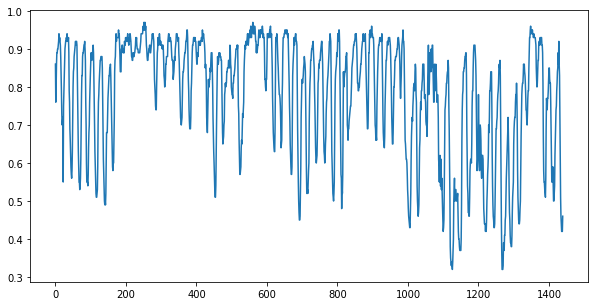

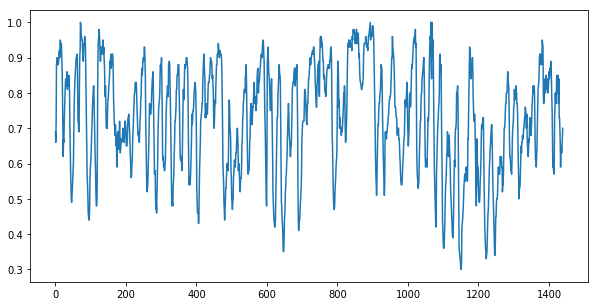

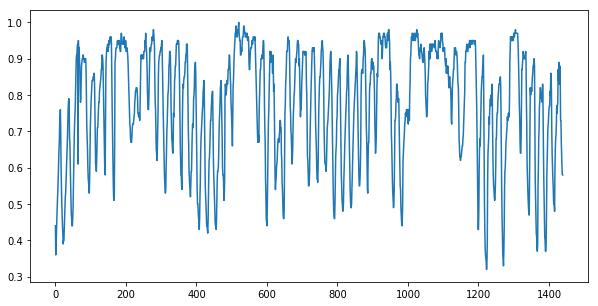

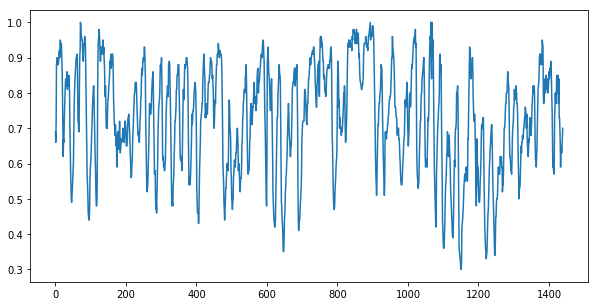

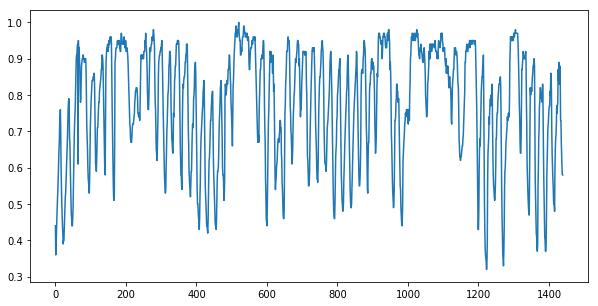

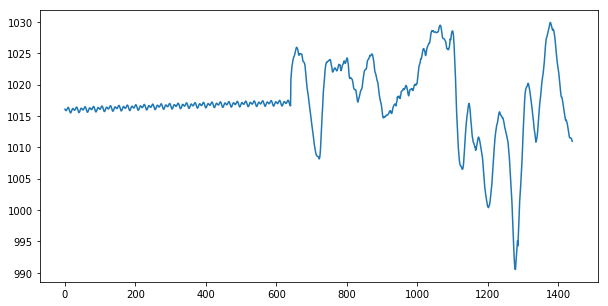

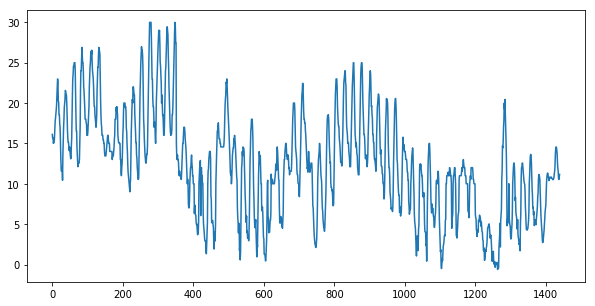

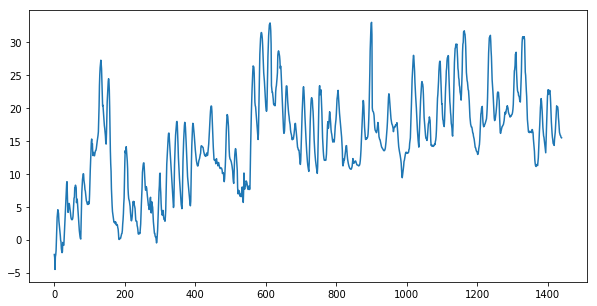

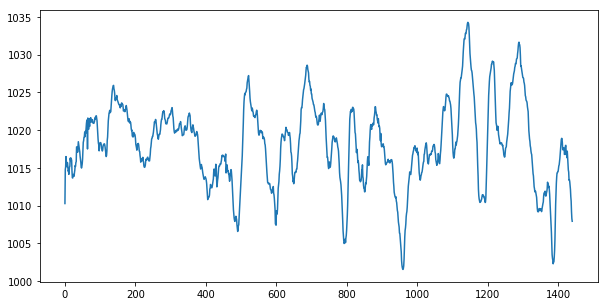

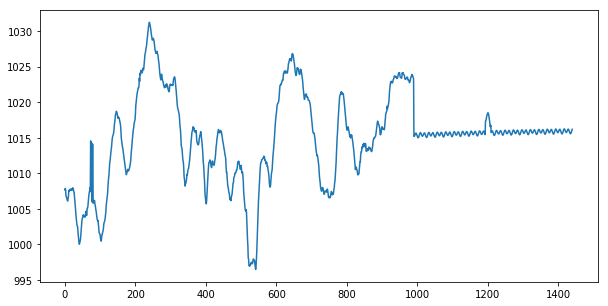

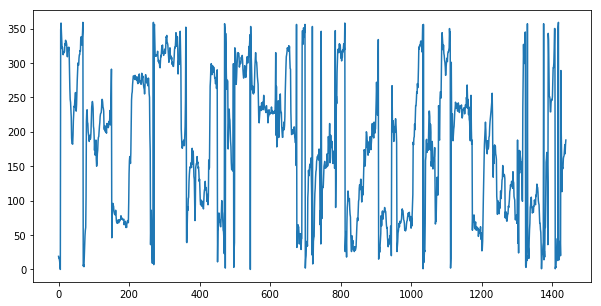

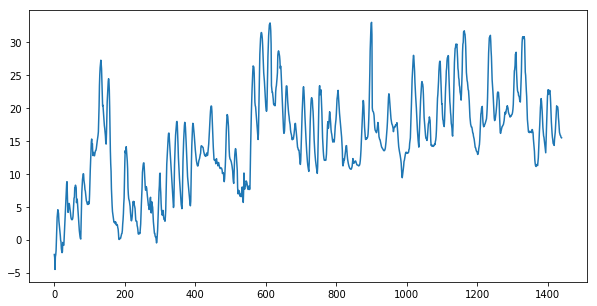

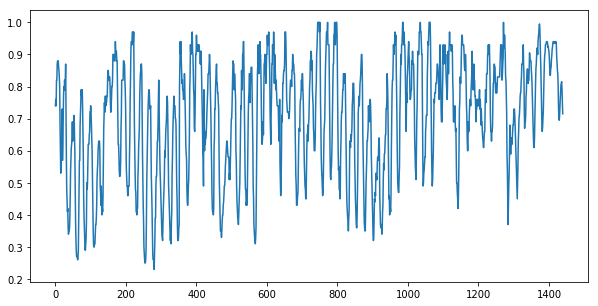

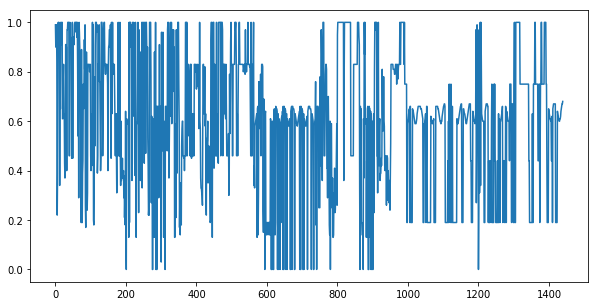

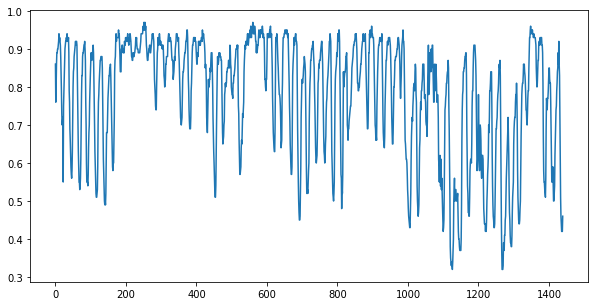

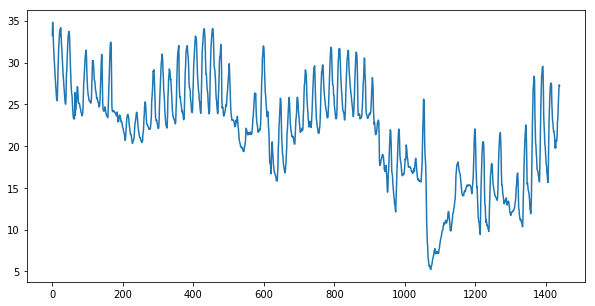

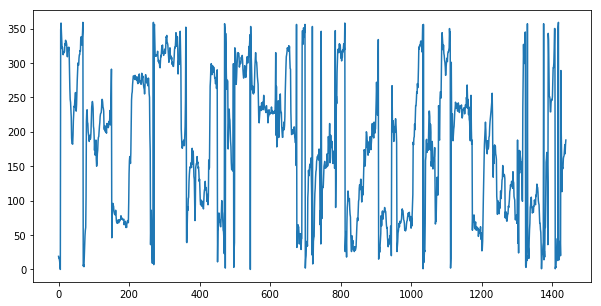

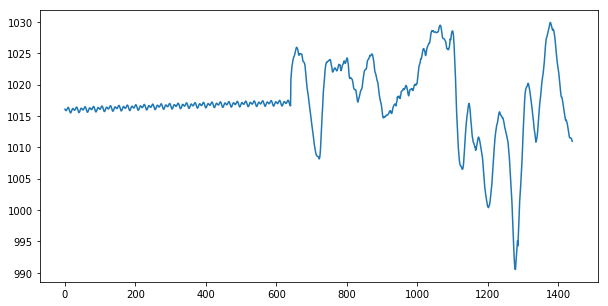

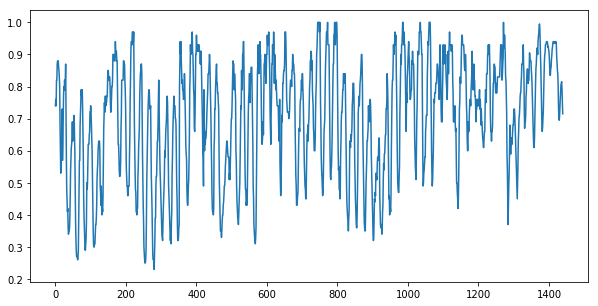

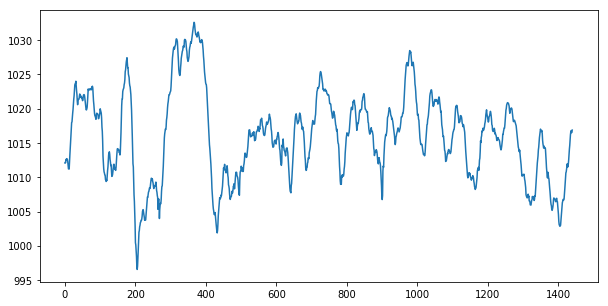

In [18]:
for i in np.random.randint(0,38, 20):
    plt.figure(figsize=(10,5))
    plt.plot(data_0[i][:1440])

### Functions

In [91]:

def sliding_window_2d(data, train_size, test_size, step_size):
    '''sliding window with an intersection between windows
    by size of _step_size_'''
    xy = []
    line_size = data.shape[1]
    for row in range(0, data.shape[0]):
        for start in range(0, line_size, step_size):
            stop =  start+train_size+test_size
            if stop <= line_size:
                xy.append(data[row, start: stop])
    return np.array(xy)


def xy_split(data, train_size):
    """split sliding windows into X and Y,
       input and output of the model.
    """
    x, y = data[:, :train_size], data[:, train_size:]
    return x, y


def norm_ts(data, transpose=True):
    """
    scaler ->  TS∈[0,1] .
    """
    scaler = MinMaxScaler(copy=True)
    if transpose:
        scaled01 = scaler.fit_transform(data.T).T
    else:
        scaled01 = scaler.fit_transform(data)
    return np.squeeze(scaled01), scaler


def inverse_norm(data, scaler):
    """ inverse scaling
    """
    return scaler.inverse_transform(data)


def train_test_reshape(train_x, test_x):
    """reshape + split train test 50-50"""
    return np.expand_dims(train_x, axis=2), np.expand_dims(test_x, axis=2)


def check_constant_2d(data):
    '''remove constant ts'''
    data_new = []
    for i in range(data.shape[0]):
        if check_constant(data[i, -24:]):
            continue
        else:
            data_new.append(data[i, :])
    return np.array(data_new)


def naive_prediction_mae(x_test, y_test):
    """prediction using last value"""
    naive_pred = 0
    n = x_test.shape[0]
    for i in range(n): 
        naive_pred += np.mean(np.abs(x_test[i, -1] - y_test[i, :]))
    naive_pred /= n
    print ('naive model = {0:0.4f}'.format(naive_pred))
    return None


def model_mae(model, x_test, y_test, scaler, inv_norm=False):
    """calculation MAE for prediction"""
    y_pred = model.predict(x_test)
    if inv_norm:
        y_pred=inverse_norm(y_pred.T, scaler).T
    mae = 0
    n = x_test.shape[0]
    for i in range(n): 
        mae += np.mean(np.abs(y_pred[i, :] - y_test[i, :]))
    mae /= n
    print ('current model = {0:0.4f}'.format(mae))
    return None

def model_mae_n(model, x_test, y_test, scaler, n, inv_norm=False):
    """calculation MAE for prediction"""
    y_pred = model.predict(x_test)
    if inv_norm:
        y_pred=inverse_norm(y_pred.T, scaler).T
    mae = 0
    for i in range(n): 
        mae += np.mean(np.abs(y_pred[i, :] - y_test[i, :]))
    mae /= n
    print ('current model = {0:0.4f}'.format(mae))
    return None


def model_mae_2_naive(model, x_test, x_test_original, y_test, scaler, inv_norm=False):
    """calculation MAE/naive ratio for prediction"""
    y_pred = model.predict(x_test)
    if inv_norm:
        y_pred=inverse_norm(y_pred.T, scaler).T
    mae_2_naive = 0
    n = x_test.shape[0]
    for i in range(n): 
        mae = np.mean(np.abs(y_pred[i, :] - y_test[i, :]))
        naive = np.mean(np.abs(x_test_original[i, -1] - y_test[i, :]))
        if naive == 0:
            print (check_constant(y_test[i, :]), y_test[i,:])
        mae_2_naive += mae / naive
    mae_2_naive /= n
    print ('current model / naive = {0:0.4f}'.format(mae_2_naive))
    return None


### Parameters of Sliding window


In [92]:

train_size = 168
test_size = 24
# line_size = v1.shape[1]
step_size = 10
train_vs_test = .75
# train_test_split = int(train_vs_test * v_1_2_4.shape[0])

### Normalization

In [93]:
train_test_split

3834

In [94]:
data= np.array(data_0)
train_test_split = int(train_vs_test * data.shape[1])

train_xy = data[:, :train_test_split]

test_xy = data[:, train_test_split:]

train_xy, scaler = norm_ts(train_xy)


train_xy = sliding_window_2d(data=train_xy,
                             train_size=train_size,
                             test_size=test_size,
                             step_size=step_size)

train_xy = check_constant_2d(train_xy)


test_xy = sliding_window_2d(data=test_xy,
                            train_size=train_size,
                            test_size=test_size,
                            step_size=step_size)

test_xy = check_constant_2d(test_xy)

test_xy.shape
test_x_original, test_y_original = xy_split(test_xy, train_size)
test_x, scaler_test = norm_ts(test_x_original, transpose=True)


train_x, train_y = xy_split(train_xy, train_size)
train_x, test_x = train_test_reshape(train_x, test_x)

print (train_x.shape, test_x.shape, test_x_original.shape, test_y_original.shape)

(12371, 168, 1) (3736, 168, 1) (3736, 168) (3736, 24)


### CNN network

In [95]:

def cnn_model(x_train, y_train, batch_size, epochs=50, n_steps_for_train=train_size):
    
    
    input_dim = n_steps_for_train
    model = Sequential()
    model.add(Convolution1D(filters=6, kernel_size=4, input_shape=(input_dim ,1)))
    model.add(Flatten())
    model.add(Dense(units=64, kernel_initializer='normal'))
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(units=60, actiivation='relu'))
    # model.add(Dense(units=40, activation='relu'))
    model.add(Dense(units=24, activation='linear'))


    sgd = optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error',
                  optimizer='sgd',
                  metrics=['mae'])

    history = model.fit(x_train, y_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_split=.3, verbose=2)
    return model, history

In [96]:
model, history = cnn_model(x_train=train_x, y_train=train_y, batch_size=4, epochs=20)

Train on 8659 samples, validate on 3712 samples
Epoch 1/20
 - 3s - loss: 0.0495 - mean_absolute_error: 0.1582 - val_loss: 0.0415 - val_mean_absolute_error: 0.1417
Epoch 2/20
 - 3s - loss: 0.0403 - mean_absolute_error: 0.1426 - val_loss: 0.0384 - val_mean_absolute_error: 0.1342
Epoch 3/20
 - 3s - loss: 0.0383 - mean_absolute_error: 0.1377 - val_loss: 0.0371 - val_mean_absolute_error: 0.1300
Epoch 4/20
 - 3s - loss: 0.0373 - mean_absolute_error: 0.1346 - val_loss: 0.0366 - val_mean_absolute_error: 0.1280
Epoch 5/20
 - 3s - loss: 0.0366 - mean_absolute_error: 0.1327 - val_loss: 0.0360 - val_mean_absolute_error: 0.1260
Epoch 6/20
 - 3s - loss: 0.0361 - mean_absolute_error: 0.1307 - val_loss: 0.0358 - val_mean_absolute_error: 0.1260
Epoch 7/20
 - 3s - loss: 0.0357 - mean_absolute_error: 0.1297 - val_loss: 0.0354 - val_mean_absolute_error: 0.1242
Epoch 8/20
 - 3s - loss: 0.0353 - mean_absolute_error: 0.1285 - val_loss: 0.0352 - val_mean_absolute_error: 0.1240
Epoch 9/20
 - 3s - loss: 0.0349 

### Comparison to Naive model

In [97]:
naive_prediction_mae(x_test=test_x_original, y_test=test_y_original)
model_mae(model, x_test=test_x, y_test=test_y_original,
          scaler=scaler_test, inv_norm=True)
model_mae_2_naive(model,
                  x_test=test_x,
                  x_test_original=test_x_original,
                  y_test = test_y_original,
                  scaler=scaler_test,
                  inv_norm=True)

naive model = 3.8057
current model = 4.0531
current model / naive = 3.8296


In [99]:
test_y_original.shape

(3736, 24)

### Comparison to Benchmark

In [98]:
import pickle
with open('../benchmark.pkl', 'rb') as handle:
    benchmark = pickle.load(handle)


model_mae(model,
          x_test=benchmark['test_x'], 
          y_test=benchmark['test_y_original'],
          scaler=benchmark['scaler_benchmark'],
          inv_norm=True)




current model = 1196.9179


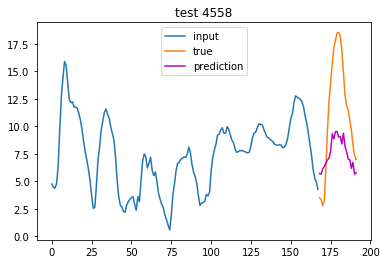

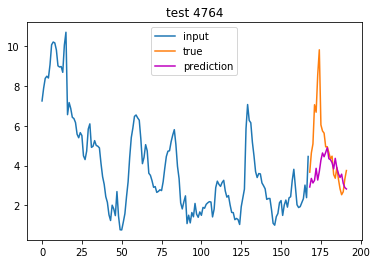

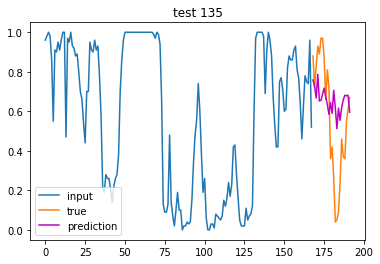

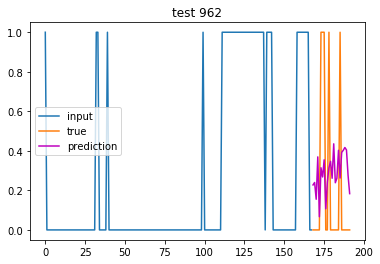

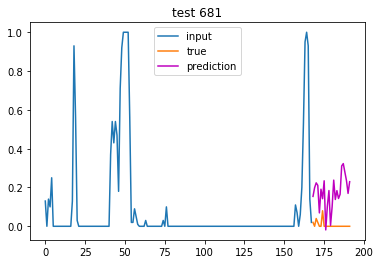

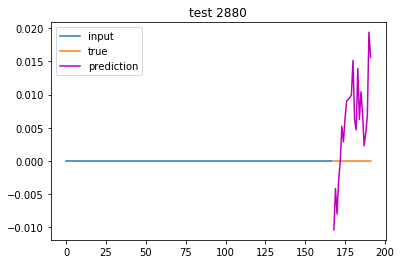

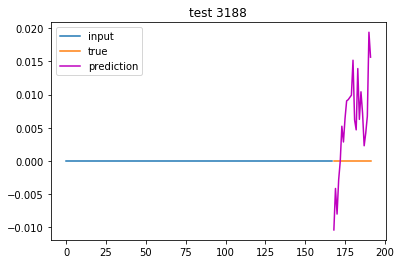

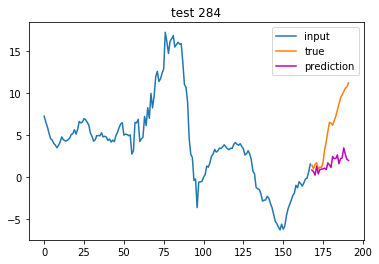

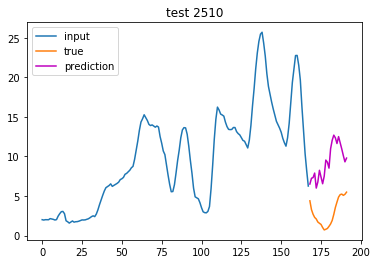

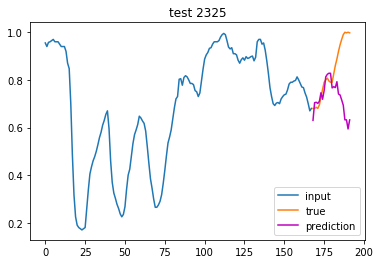

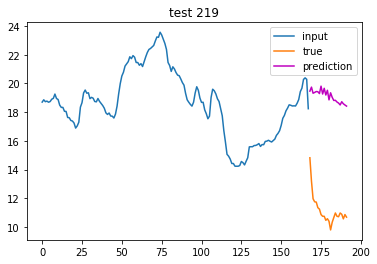

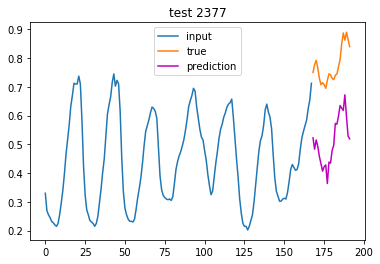

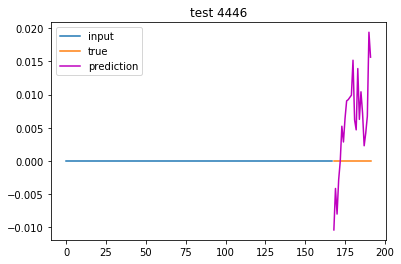

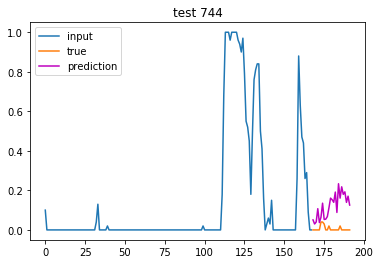

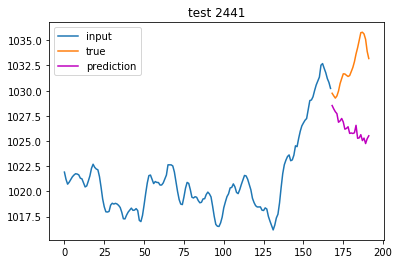

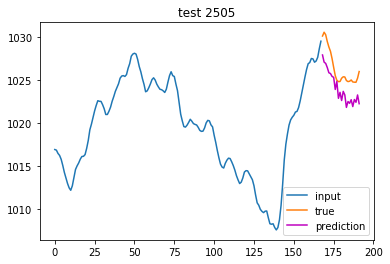

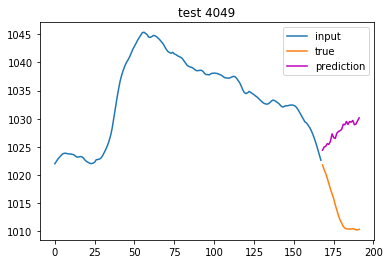

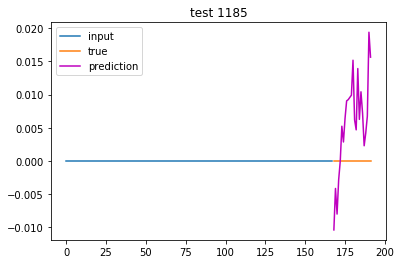

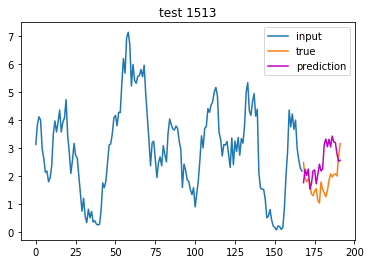

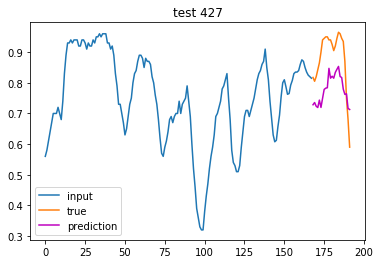

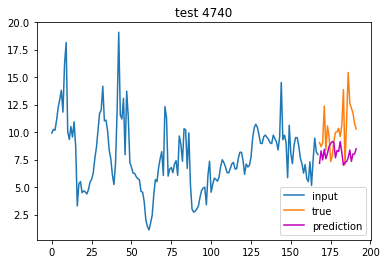

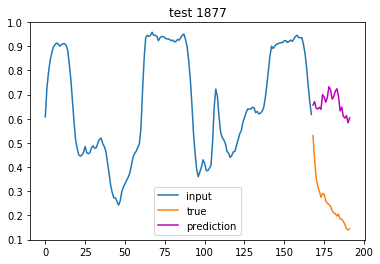

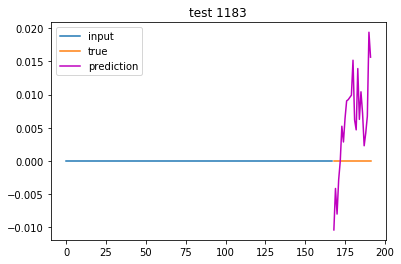

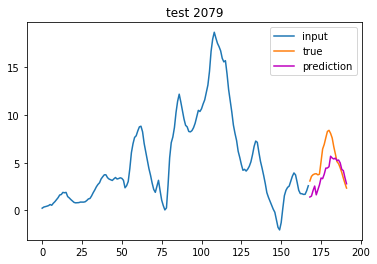

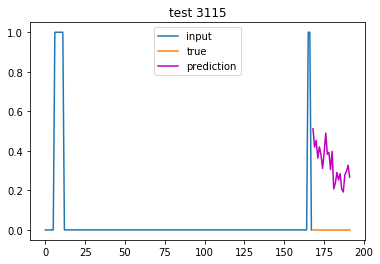

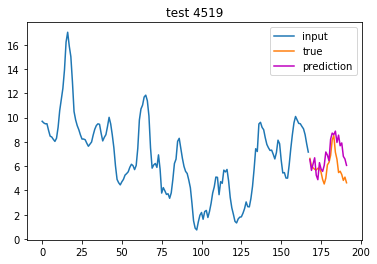

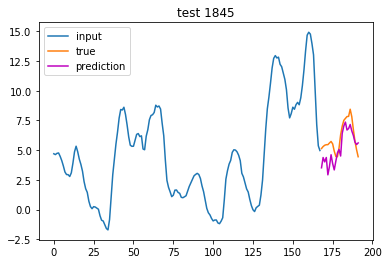

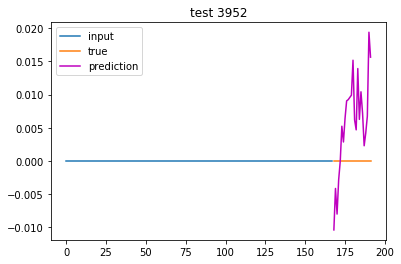

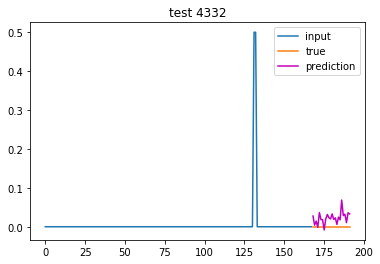

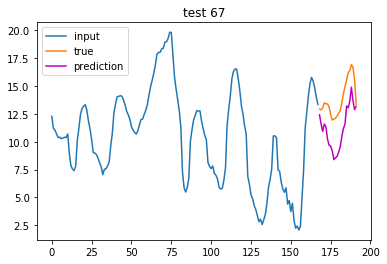

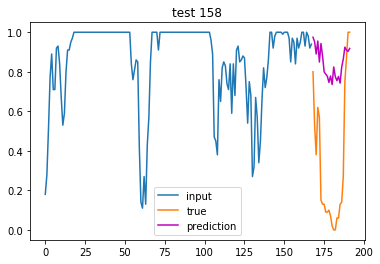

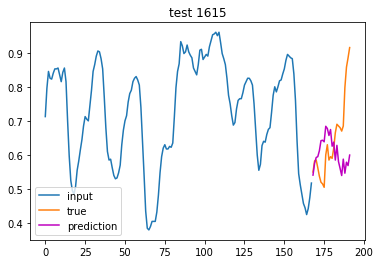

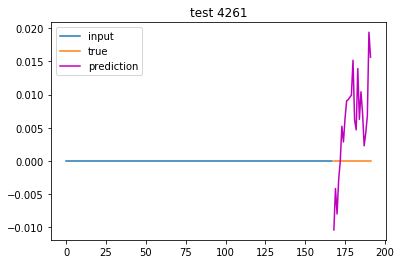

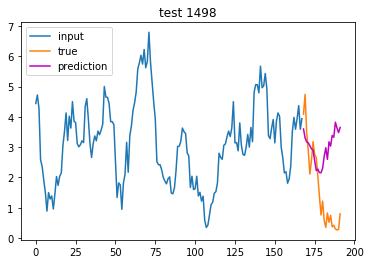

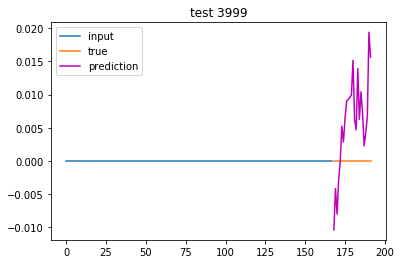

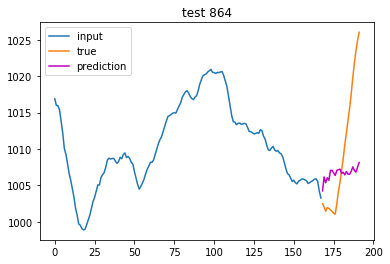

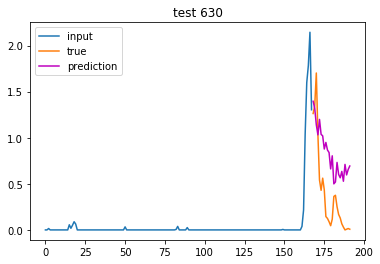

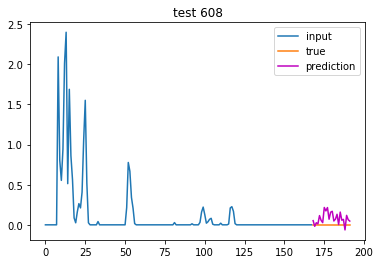

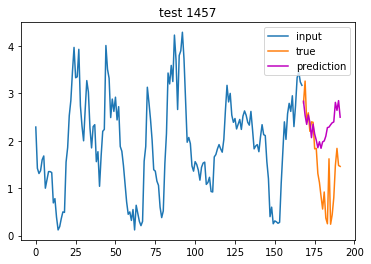

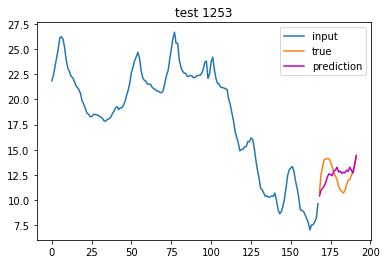

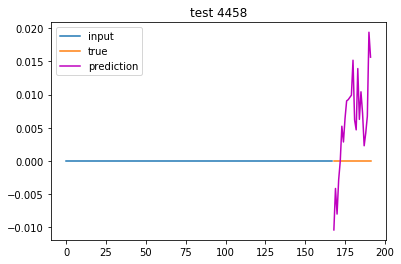

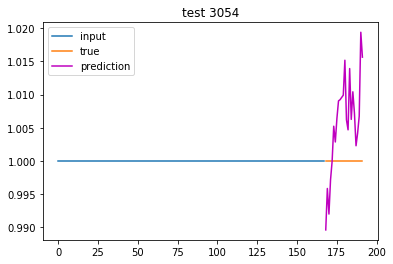

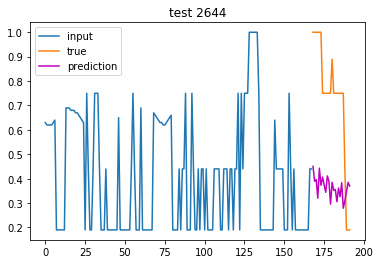

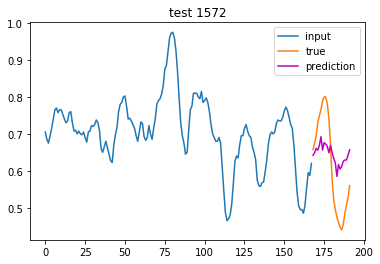

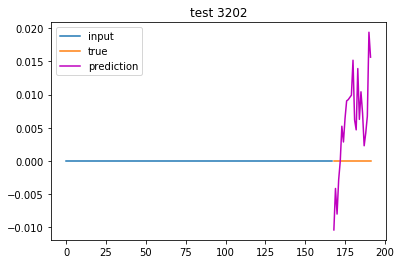

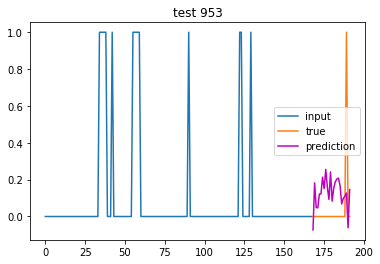

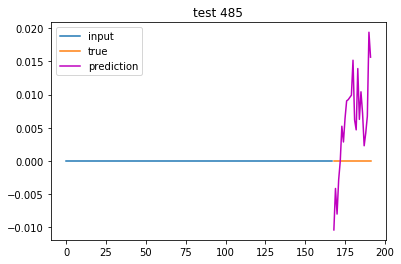

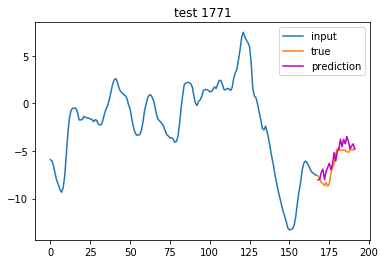

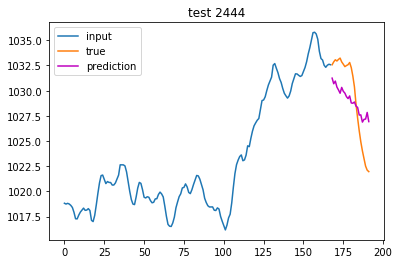

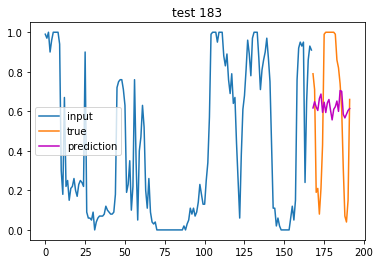

In [14]:
plt.rcParams.update({'figure.max_open_warning': 50})
np.random.seed(seed=124)
pred = model.predict(test_x)
pred = inverse_norm(pred.T, scaler=scaler_test).T
for i in np.random.randint(0, test_x.shape[0], 50):
    plt.figure()
    plt.plot(range(train_size), test_x_original[i], label='input')
    plt.plot(range(train_size, train_size+test_size), test_y_original[i], label='true')
    plt.plot(range(train_size, train_size+test_size), pred[i], c='m', label='prediction')
    plt.title(f'test {i}')
    plt.legend()

In [20]:
len(set(np.array([1,2,3])))

3